# Import libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer

# Import dataset

In [2]:
df = pd.read_csv('data.csv')

# Data preparation

In [3]:
df.rename(columns={'MSRP': 'price'}, inplace=True)
df = df[['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
          'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'price']]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.fillna(0, inplace=True)
df.head()   

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


# Question 1

In [4]:
df['transmission_type'].value_counts()

transmission_type
AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: count, dtype: int64

The most frequent obervation is **Automatic**

# Question 2

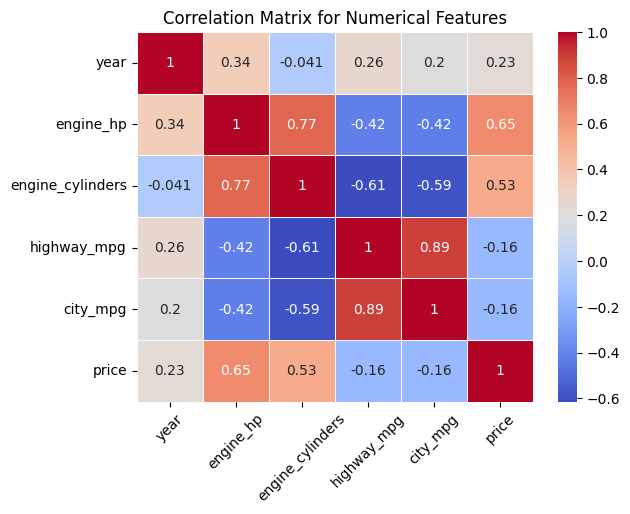

In [5]:
numerical_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_columns.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.xticks(rotation=45)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

From the options below, the highest correlation pairs are:
- `engine_hp` and `engine_cylinders`
- `highway_mpg` and `city_mpg`

# Make `Price` binary

In [6]:
mean_price = df['price'].mean()
df['above_average']=(df['price'] > mean_price).astype(int)

# Split the data

In [7]:
seed = 42

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.2, random_state=seed)

def extract_features_target(dataset):
    X = dataset.drop(columns=['price'])
    y = dataset['price']
    return X, y
X_train, y_train = extract_features_target(train_df)
X_val, y_val = extract_features_target(val_df)
X_test, y_test = extract_features_target(test_df)

# Question 3

In [8]:
categorical_columns = df.select_dtypes(include=['object']).columns
data_encoded = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)

mi_scores = mutual_info_classif(data_encoded.drop(columns=['above_average']), train_df['above_average'], random_state=42)
mi_scores_df = pd.DataFrame({'Feature': data_encoded.drop(columns=['above_average']).columns, 'MI Score': mi_scores})

mi_scores_df['Feature'] = mi_scores_df['Feature'].str.split('_', expand=True)[0]
mi_scores_df.groupby('Feature').agg({'MI Score': 'mean'}).sort_values(by='MI Score', ascending=False)

,MI Score
Feature,
price,0.589208
engine,0.234673
year,0.067576
city,0.066452
highway,0.043498
vehicle,0.007926
make,0.005539
transmission,0.004011
model,0.002377


The variable that has the lowest mutual information score is `model`

# Question 4

In [12]:
# define the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Separate the target variable (y) from the features (X)
X = df.drop('above_average', axis=1)  # Replace 'target_column' with the actual target column name
y = df['above_average']

# Apply one-hot encoding to categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_encoded = encoder.fit_transform(X[categorical_columns])

# Get the feature names after one-hot encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)

# Concatenate the one-hot encoded features with the remaining numeric features
X_processed = pd.concat([X.drop(categorical_columns, axis=1), X_encoded_df], axis=1)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_valid)

# Calculate accuracy and round it to 2 decimal digits
accuracy = accuracy_score(y_valid, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

d:\MLZoomCamp\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.9991607217792698


From the result above we can conclude the closest accuracy in the options is **0.95**

# Question 5

In [15]:
# define the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Separate the target variable (y) from the features (X)
X = df.drop('above_average', axis=1)  # Replace 'target_column' with the actual target column name
y = df['above_average']

# Apply one-hot encoding to categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_encoded = encoder.fit_transform(X[categorical_columns])

# Get the feature names after one-hot encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)

# Concatenate the one-hot encoded features with the remaining numeric features
X_processed = pd.concat([X.drop(categorical_columns, axis=1), X_encoded_df], axis=1)

# Initialize the Logistic Regression model
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

# Initialize RFE with Logistic Regression model as the estimator
rfe = RFE(model, n_features_to_select=1)

# Fit RFE on training data
rfe.fit(X_train, y_train)

# Get the ranking of each feature
feature_ranking = rfe.ranking_

# Create a dictionary to store feature names and their rankings
feature_rank_dict = dict(zip(X_train.columns, feature_ranking))

# Sort features by their ranking (ascending order)
sorted_features = sorted(feature_rank_dict, key=feature_rank_dict.get)

# Print the feature with the smallest ranking (1 indicates most important)
print("The feature with the smallest ranking is:", sorted_features[0])

d:\MLZoomCamp\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The feature with the smallest ranking is: year


From the result above we can see the feature with the smallest ranking is **Year**

# Question 6

In [ ]:
# Apply logarithmic transformation to the 'price' column
df['price'] = np.log1p(df['price'])

# Split the data into training and testing sets
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Create transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create an empty DataFrame to store RMSE scores
rmse_scores = []

# Initialize the alpha values
alphas = [0, 0.01, 0.1, 1, 10]

# Fit Ridge regression models with different alpha values
for alpha in alphas:
    ridge = Ridge(alpha=alpha, solver='sag', random_state=42)
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', ridge)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append({'Alpha': alpha, 'RMSE': round(rmse, 3)})

# Convert the list of dictionaries to a DataFrame
rmse_scores_df = pd.DataFrame(rmse_scores)
print(rmse_scores_df)

The best RMSE score is 0.227 for the number of alpha is **0.10**